In [1]:
%load_ext autoreload
%autoreload 2

In [87]:
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import cosmology
from astropy import coordinates
from astropy.io import ascii
from astropy import table
from SAGAbg.utils import functional_forms

In [56]:
cosmo = cosmology.FlatLambdaCDM ( 70., 0.3 )

In [67]:
saga_smf = np.load('../local_data/scratch/primary_smf.npy')

In [82]:
primary_color =  "#ff5a00"

In [6]:
karachentsev_basic = ascii.read('../../karachentsev/table1.dat', readme='../../karachentsev/ReadMe')
karachentsev_phot = ascii.read('../../karachentsev/table2.dat', readme='../../karachentsev/ReadMe')

In [107]:
logml = lambda bk: 0.498*bk - 2.141
logmstar = logml(karachentsev_basic['Bmag'] - karachentsev_basic['Kmag']) + karachentsev_phot['KLum']

In [108]:
kcoords = [ f"{x['RAh']}h{x['RAm']}m{x['RAs']}s {x['DE-']}{x['DEd']}d{x['DEm']}m{x['DEs']}s" for x in karachentsev_phot ]
kcoords = coordinates.SkyCoord ( kcoords, unit=('hourangle','deg'), )

In [109]:
dbins = np.arange(0.01,11.,0.1)
assns = np.digitize ( karachentsev_basic['Dist'], dbins )

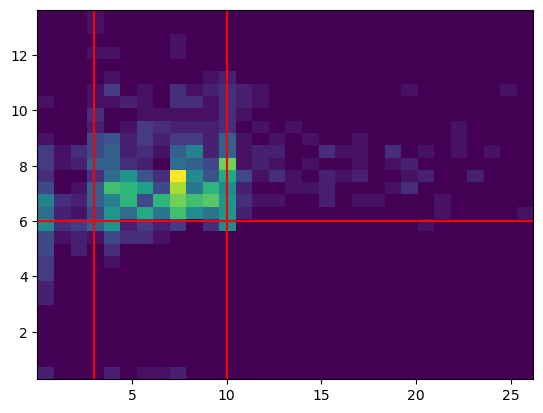

In [223]:
plt.hist2d ( karachentsev_basic['Dist'], logmstar, bins=30)
dmin = 3.
dmax = 10.
massmin = 6.
plt.axhline(massmin, color='r')
plt.axvline(dmin, color='r')
plt.axvline(dmax,color='r')

In [224]:
complete_sample = (karachentsev_basic['Dist']>dmin)&(karachentsev_basic['Dist']<dmax)&(logmstar > massmin)

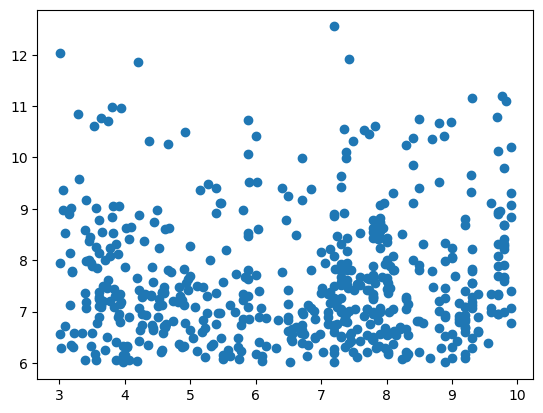

In [225]:
plt.scatter ( karachentsev_basic['Dist'][complete_sample], logmstar[complete_sample] )

In [226]:
kbins = np.linspace(6., 10., 10)
kbins_midpts = 0.5*(kbins[1:]+kbins[:-1])

In [227]:
kassns = np.digitize ( logmstar[complete_sample], kbins )

In [228]:
effective_volume = 4./3. * np.pi * ( dmax**3 - dmin**3 )

In [229]:
cts, _ = np.histogram ( karachentsev_phot['KLum'][complete_sample], bins=kbins )

In [230]:
# \\ add GAMA comparison
# \\ construct SMF from Wright et al. 2017
smf1_args = (2.93e-3, 10.78, -0.62 )
smf2_args = (0.63e-3, 10.78, -1.50 )

dbl_schechter = lambda x: functional_forms.logschechter_alog(x,*smf1_args) + \
                functional_forms.logschechter_alog(x, *smf2_args )
gama_mass = np.linspace(7.5, 11., 30)
gama_extend = np.linspace(6.5, 7.5, 30)


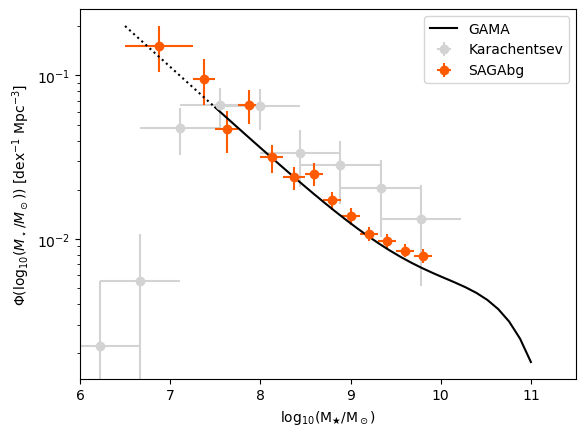

In [231]:
plt.plot ( gama_mass, dbl_schechter(gama_mass), color='k', ls='-', label='GAMA')
plt.plot ( gama_extend, dbl_schechter(gama_extend), color='k', ls=':')

plt.errorbar ( kbins_midpts, cts/effective_volume/np.diff(kbins), fmt='o', 
              xerr = np.diff(kbins), 
              yerr=3.*np.sqrt(cts)/effective_volume/np.diff(kbins), 
             color='lightgrey', label='Karachentsev')
                    #, np.zeros_like(cts)], marker='^')
plt.errorbar ( saga_smf[0,0], saga_smf[1,0], xerr=saga_smf[0,1], yerr=3.*saga_smf[1,1], fmt='o', color=primary_color, label='SAGAbg' )
plt.yscale('log')
plt.xlabel(r'$\log_{10}(\rm M_\bigstar/M_\odot)$')
plt.ylabel(r'$\Phi(\log_{10}(M_\star/M_\odot))$ [dex$^{-1}$ Mpc$^{-3}$]')
plt.xlim(6.,11.5)
plt.legend ()
plt.savefig('../figures/SAGAbg_primary_smf.png')